<a href="https://colab.research.google.com/github/qorganbek/ComputerVision-Spring-2024/blob/main/CTC_on_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from tqdm import tqdm

In [ ]:
epochs = 5
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 32
digits_per_sequence = 5
number_of_sequences = 10000
# emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
emnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
dataset_sequences = []
dataset_labels = []



In [ ]:
for i in range(number_of_sequences):
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    for img in random_digits_images:
        img = transforms.ToPILImage()(img)
        img = TF.rotate(img, -90, fill=0)
        img = TF.hflip(img)
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_labels = emnist_dataset.targets[random_indices]
    random_sequence = np.hstack(random_digits_images.reshape(digits_per_sequence, 28, 28))
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)

dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [ ]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [ ]:
model = CRNN().cuda()
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for _ in range(epochs):
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train.cuda())
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)


100%|██████████| 125/125 [00:07<00:00, 15.99it/s]
TRAINING. Correct:  0 / 8000 = 0.0
100%|██████████| 125/125 [00:06<00:00, 20.24it/s]
TRAINING. Correct:  2945 / 8000 = 0.368125
100%|██████████| 125/125 [00:05<00:00, 21.23it/s]
TRAINING. Correct:  6396 / 8000 = 0.7995
100%|██████████| 125/125 [00:06<00:00, 18.11it/s]
TRAINING. Correct:  7040 / 8000 = 0.88
100%|██████████| 125/125 [00:05<00:00, 21.19it/s]
TRAINING. Correct:  7285 / 8000 = 0.910625


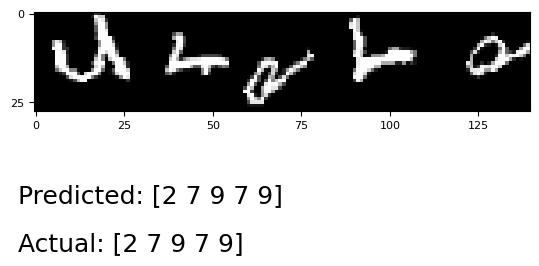

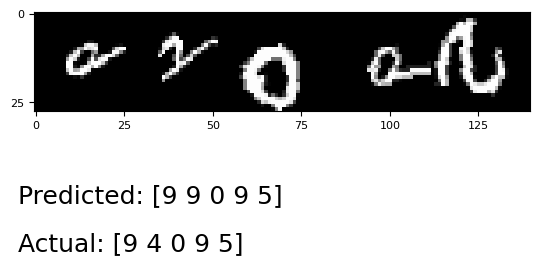

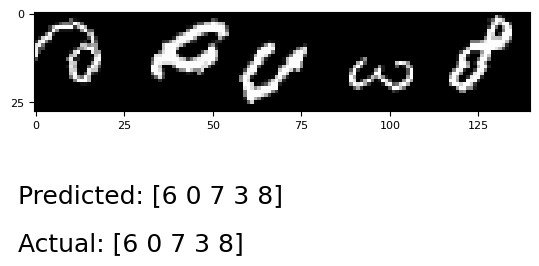

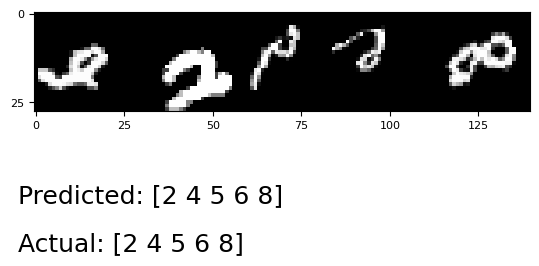

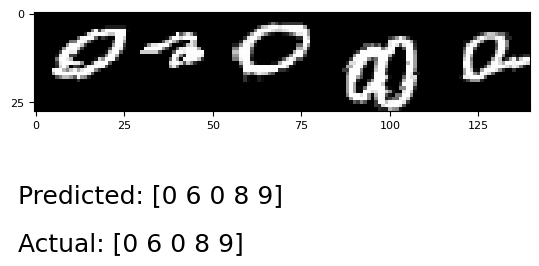

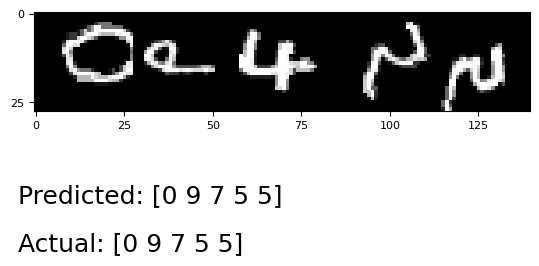

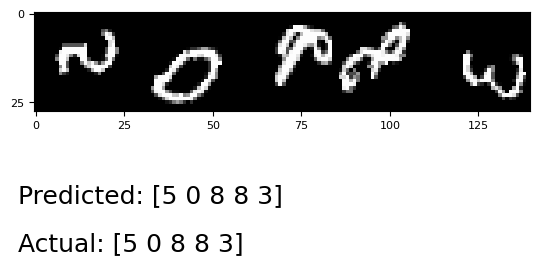

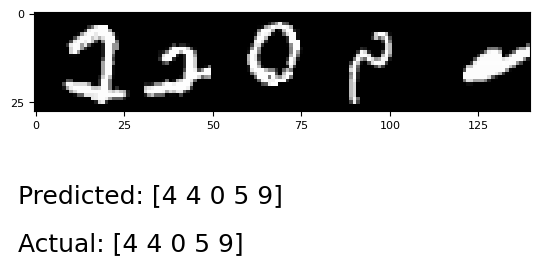

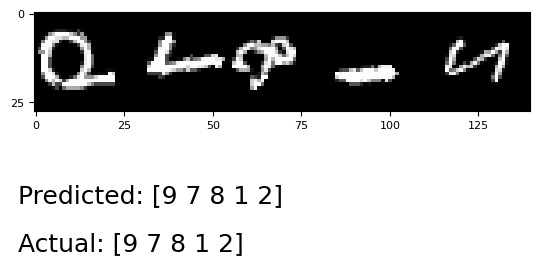

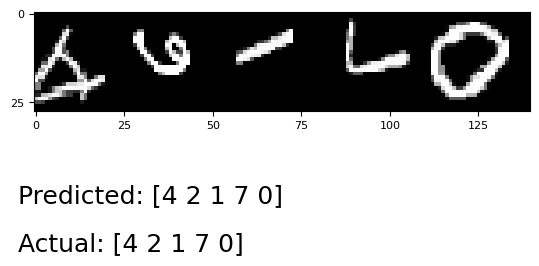

In [ ]:
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()

In [ ]:
#Task rerun this code for length of sequence from 5 to 10 and calculate metrics (you can choose is by you own for test data)
#replace accuracy function

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from nltk.metrics import edit_distance

# Define the model and other necessary variables (as per your setup)

# Metrics storage
results = {}

# Iterate through sequence lengths from 5 to 10
for sequence_length in range(5, 11):
    # Adjust the test data and model for the current sequence length
    # (e.g., by creating subsets of data with the current sequence length)

    # Initialize metrics storage for the current sequence length
    total_edit_distance = 0
    total_length = 0

    # Evaluate the model on the test data
    for x_test, y_test in test_loader:
        # Adjust the data to match the current sequence length (if needed)

        # Forward pass
        y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
        y_pred = y_pred.permute(1, 0, 2)

        # Process predictions
        _, max_index = torch.max(y_pred, dim=2)
        predictions = []

        # Decode predictions and compare with true labels
        for i in range(x_test.shape[0]):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            predictions.append(prediction)

            # Calculate edit distance
            total_edit_distance += edit_distance(y_test[i].tolist(), prediction.tolist())
            total_length += len(y_test[i])

        # Calculate other metrics as needed (e.g., confusion matrix, F1-score)
        # conf_matrix = confusion_matrix(y_test, predictions)
        # classification_report(y_test, predictions)

    # Calculate average metrics for the current sequence length
    avg_edit_distance = total_edit_distance / total_length

    # Store results
    results[sequence_length] = {
        'average_edit_distance': avg_edit_distance
        # Include other metrics as needed (e.g., confusion matrix, F1-score)
    }

    # Output results for the current sequence length
    print(f"Sequence Length: {sequence_length}")
    print(f"Average Edit Distance: {avg_edit_distance}")
    # Output other metrics as needed

# Output final results
print("Final Results:")
for seq_length, metrics in results.items():
    print(f"Sequence Length: {seq_length}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value}")


Sequence Length: 5
Average Edit Distance: 0.0325
Sequence Length: 6
Average Edit Distance: 0.0325
Sequence Length: 7
Average Edit Distance: 0.0325
Sequence Length: 8
Average Edit Distance: 0.0325
Sequence Length: 9
Average Edit Distance: 0.0325
Sequence Length: 10
Average Edit Distance: 0.0325
Final Results:
Sequence Length: 5
  average_edit_distance: 0.0325
Sequence Length: 6
  average_edit_distance: 0.0325
Sequence Length: 7
  average_edit_distance: 0.0325
Sequence Length: 8
  average_edit_distance: 0.0325
Sequence Length: 9
  average_edit_distance: 0.0325
Sequence Length: 10
  average_edit_distance: 0.0325
